In [1]:
import numpy as np
import plotly.graph_objects as go

In [2]:
'''
The definitions of Rotation Matrices
--------------------------------------------------------------------------------------------------------------------------------------------------------
    - The rotation abt the 1st principle axis (x-axis) is defined by the angle 'psi'
    - The rotation abt the 2nd principle axis (y-axis) is defined by the angle 'theta'
    - The rotation abt the 3rd principle axis (z-axis) is defined by the angle 'phi'
'''

def rotation_matrix_x(phi):
    """Generate rotation matrix for a roll (rotation about the x-axis)"""
    phi = np.radians(phi)
    c, s = np.cos(phi), np.sin(phi)
    return np.array([[1, 0, 0], 
                     [0, c, s], 
                     [0, -s, c]])

def rotation_matrix_y(theta):
    """Generate rotation matrix for a pitch (rotation about the y-axis)"""
    theta = np.radians(theta)
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, 0, -s], 
                     [0, 1, 0], 
                     [s, 0, c]])

def rotation_matrix_z(psi):
    """Generate rotation matrix for a yaw (rotation about the z-axis)"""
    psi = np.radians(psi)
    c, s = np.cos(psi), np.sin(psi)
    return np.array([[c, s, 0], 
                     [-s, c, 0], 
                     [0, 0, 1]])

In [3]:
def quaternion_to_DCM(q):
    """
    Converts a quaternion to a direction cosine matrix (DCM).

    Args:
        q (np.array): A numpy array of size 4 (a row vector) representing the quaternion,
                      where q[0] is the scalar part (beta_0), and q[1], q[2], q[3] are the 
                      vector parts (beta_1, beta_2, beta_3).

    Returns:
        np.array: A 3x3 rotation matrix (DCM).

    Example:
        >>> q = np.array([1, 5, 6, 2])
        >>> quaternion_to_DCM(q)
        array([[ 0.38461538, -0.07692308,  0.91923077],
               [ 0.07692308,  0.99230769, -0.09615385],
               [-0.91923077,  0.09615385,  0.38461538]])
    """
    # Ensure q is a float array to maintain precision
    q = np.array(q, dtype=np.float64)
    
    # Check that the holonomic constraint of quaternion is satisfied, else normalize it
    q_norm = np.linalg.norm(q)
    if not np.isclose(q_norm, 1.0, atol=1e-8):
        q /= q_norm
    
    # Extract components
    q0, q1, q2, q3 = q
    
    # Compute the elements of the DCM
    C = np.array([
        [q0**2 + q1**2 - q2**2 - q3**2, 2 * (q1*q2 + q0*q3),         2 * (q1*q3 - q0*q2)],
        [2 * (q1*q2 - q0*q3),           q0**2 - q1**2 + q2**2 - q3**2, 2 * (q2*q3 + q0*q1)],
        [2 * (q1*q3 + q0*q2),           2 * (q2*q3 - q0*q1),           q0**2 - q1**2 - q2**2 + q3**2]
    ])
    
    return C

# Example usage:
q = np.array([-1, 5, 6, 2])
C = quaternion_to_DCM(q)
print("Direction Cosine Matrix (DCM):\n", C)

Direction Cosine Matrix (DCM):
 [[-0.21212121  0.84848485  0.48484848]
 [ 0.96969697  0.12121212  0.21212121]
 [ 0.12121212  0.51515152 -0.84848485]]


In [4]:
def DCM_to_quaternion(dcm):
    """
    Converts a Direction Cosine Matrix (DCM) to a quaternion using a method to ensure robustness against numerical issues.
    
    Args:
        dcm (np.array): A 3x3 rotation matrix (DCM).
    
    Returns:
        np.array: A quaternion represented as a numpy array of size 4, with the scalar component as the first element.
    
    Example Usage:
        >>> dcm = np.array([[-0.21212121, 0.96969697, 0.12121212],
                            [0.84848485, 0.12121212, 0.51515152],
                            [0.48484848, 0.21212121, -0.84848485]])
        >>> quaternion = DCM_to_quaternion(dcm)
        >>> print(quaternion)
    
    Notes:
    - If the scalar component (q0) is negative, it is flipped to positive. (Ensuring shortes path of rotation)
    - Corresponding vector component is also flipped when q0 is flipped. (Shepperd's Method)
    - Flipping maintains the quaternion's correct rotational encoding.
    - Ensures the quaternion represents a rotation of less than 180 degrees.
    - Adheres to quaternion algebra for accurate 3D rotation representation.
    """
    trace = np.trace(dcm)
    q_squared = np.zeros(4)
    q_squared[0] = (1.0 + trace) / 4.0
    q_squared[1] = (1.0 + 2 * dcm[0, 0] - trace) / 4.0
    q_squared[2] = (1.0 + 2 * dcm[1, 1] - trace) / 4.0
    q_squared[3] = (1.0 + 2 * dcm[2, 2] - trace) / 4.0

    q = np.zeros(4)
    max_index = np.argmax(q_squared)

    if max_index == 0:
        q[0] = np.sqrt(q_squared[0])
        q[1] = (dcm[1, 2] - dcm[2, 1]) / (4 * q[0])
        q[2] = (dcm[2, 0] - dcm[0, 2]) / (4 * q[0])
        q[3] = (dcm[0, 1] - dcm[1, 0]) / (4 * q[0])
    
    elif max_index == 1:
        q[1] = np.sqrt(q_squared[1])
        q[0] = (dcm[1, 2] - dcm[2, 1]) / (4 * q[1])
        if q[0] < 0:
            q[0] = -q[0]
            q[1] = -q[1]
            
        q[2] = (dcm[0, 1] + dcm[1, 0]) / (4 * q[1])
        q[3] = (dcm[2, 0] + dcm[0, 2]) / (4 * q[1])
        
    elif max_index == 2:
        q[2] = np.sqrt(q_squared[2])
        q[0] = (dcm[2, 0] - dcm[0, 2]) / (4 * q[2])
        if q[0] < 0:
            q[0] = -q[0]
            q[2] = -q[2]
        q[1] = (dcm[0, 1] + dcm[1, 0]) / (4 * q[2])
        q[3] = (dcm[1, 2] + dcm[2, 1]) / (4 * q[2])

    elif max_index == 3:
        q[3] = np.sqrt(q_squared[3])
        q[0] = (dcm[0, 1] - dcm[1, 0]) / (4 * q[3])
        if q[0] < 0:
            q[0] = -q[0]
            q[3] = -q[3]
            
        q[1] = (dcm[2, 0] + dcm[0, 2]) / (4 * q[3])
        q[2] = (dcm[1, 2] + dcm[2, 1]) / (4 * q[3])
    
    return q

# Example Usage
dcm = np.array([[-0.21212121,  0.84848485,  0.48484848],
                [ 0.96969697,  0.12121212,  0.21212121],
                [ 0.12121212,  0.51515152, -0.84848485]])
quaternion = DCM_to_quaternion(dcm)
print(quaternion)

[ 0.12309149 -0.61545746 -0.73854895 -0.24618298]


In [5]:
def slerp(q0, q1, t_array):
    """
    Performs spherical linear interpolation between two quaternions.

    Args:
        q0 (np.ndarray): The starting quaternion.
        q1 (np.ndarray): The ending quaternion.
        t_array (np.ndarray): An array of interpolation factors from 0 to 1.

    Returns:
        list: A list of interpolated quaternions.
    """
    q0 = q0 / np.linalg.norm(q0)
    q1 = q1 / np.linalg.norm(q1)
    dot_product = np.dot(q0, q1)

    # Adjust quaternions if necessary
    if dot_product < 0.0:
        q1 = -q1
        dot_product = -dot_product

    if dot_product > 0.9995:
        # Quaternions are nearly identical, use linear interpolation
        interpolated_quaternions = [q0 + t * (q1 - q0) for t in t_array]
    else:
        theta_0 = np.arccos(dot_product)
        sin_theta_0 = np.sin(theta_0)
        interpolated_quaternions = [
            (np.sin((1 - t) * theta_0) / sin_theta_0) * q0 + (np.sin(t * theta_0) / sin_theta_0) * q1
            for t in t_array
        ]

    # Normalize the interpolated quaternions
    interpolated_quaternions = [q / np.linalg.norm(q) for q in interpolated_quaternions]
    return interpolated_quaternions

In [6]:
def initialize_ref_frame(fig, frame_matrix, frame_label, colors, is_static=False):
    """
    Initializes vectors on the provided Plotly figure as either static or dynamic using a color dictionary.

    Args:
        fig (plotly.graph_objects.Figure): The figure to which the frame vectors will be added.
        frame_matrix (np.ndarray): A 3x3 matrix representing the orientation of the frame, where each column is a unit vector (i, j, k).
        frame_label (str): The base label for the frame vectors ('N' for the N-frame, 'E' for the E-frame).
        colors (dict): A dictionary specifying the colors for each vector, keyed by 'i', 'j', 'k'.
        is_static (bool, optional): If True, the frame will be added as static (with dotted lines). 
                                    If False, it will be added as dynamic (with solid lines). 
                                    Defaults to False.

    Returns:
        list: A list of trace indices added to the figure.

    Note:
        - This function modifies the provided `fig` object in place by adding traces representing the frame vectors. It does not return a new figure.
        - The `line_style` is set to 'dot' for static frames and 'solid' for dynamic frames to visually distinguish between them.
        - The function uses the `frame_matrix` to extract the vectors corresponding to the axes (i, j, k) 
          and assigns the specified colors from the `colors` dictionary.
        - The `frame_label` is appended with a suffix to indicate whether the frame is static or dynamic.
        - The `trace_indices` list stores the indices of the added traces. 
          The `len(fig.data) - 1` expression is used to get the index of the most recently added trace, 
          as `len(fig.data)` gives the total number of traces in the figure, and subtracting 1 gives the index of the last added trace.

    Example:
        colors = {'i': 'red', 'j': 'green', 'k': 'blue'}
        frame_matrix = np.eye(3)
        fig = go.Figure()
        trace_indices = initialize_ref_frame(fig, frame_matrix, 'N', colors, is_static=True)
        print(trace_indices)  # Output should be [0, 1, 2] for the first call
    """
    line_style = 'dot' if is_static else 'solid'
    
    suffix = " (static)" if is_static else ""
    
    axis_labels = ['i', 'j', 'k'] 

    trace_indices = []

    for i, axis in enumerate(axis_labels):
        vec = frame_matrix[i, :]
        name = f'{frame_label}_{axis}{suffix}'
        color = colors[axis]  # Access color using axis label as key
        trace = go.Scatter3d(x=[0, vec[0]], 
                             y=[0, vec[1]], 
                             z=[0, vec[2]],
                             mode='lines+markers', 
                             name=name,
                             marker=dict(color=color),
                             line=dict(dash=line_style, color=color))
        fig.add_trace(trace)

        trace_indices.append(len(fig.data)-1)

    return trace_indices

In [7]:
def setup_animation_scene(fig, frames, title):
    """
    Adds animation controls and configures layout settings for a Plotly figure.

    Args:
        fig (plotly.graph_objects.Figure): The figure to which the controls will be added.
        frames (list): List of animation frames to be included in the slider control.
        title (str): The title to set for the animation scene.

    Note:
    - Animation Controls: This function sets up interactive controls that allow users to play through or step through the animation frames at their own pace. 
                          The 'Play' button starts the animation, while the slider allows users to jump to specific points in the animation.
    
    - Button Configuration: The 'Play' button is configured to start the animation immediately when clicked, using the 'immediate' mode. 
                            It ensures that the animation runs smoothly, redrawing each frame with a duration of 100 milliseconds.
    
    - Slider Mechanism: The slider below the animation includes steps corresponding to each frame created in the animation sequence. 
                        Users can move the slider to navigate to different frames, which is particularly useful for examining specific moments of the animation in detail.
    
    - Current Value Display: The slider also shows the current frame number as the animation plays, 
                             providing immediate visual feedback to users on their current position within the animation sequence.
    
    - Layout Configuration: The function also defines the visual layout of the 3D scene. 
                            It sets a fixed cube aspect for the axes to ensure that objects in the 3D space are displayed proportionally. 
                            The axes are configured to not auto-scale, maintaining consistent spatial references.
    
    - Scene Dimensions: The overall dimensions of the figure are set to ensure sufficient space for viewing the animation comfortably, enhancing the visual experience for the user.
    
    - Usability and Interactivity: By integrating these controls, the function enhances the usability and interactivity of the visualization, 
                                   making it a more effective tool for presentations or educational purposes where step-by-step analysis of movements is beneficial.

    """
    # Update the figure with animation controls
    fig.update_layout(updatemenus=[{"type": "buttons",
                                    "showactive": False,
                                    "y": -0.13,
                                    "x": -0.02,
                                    "xanchor": 'left',
                                    "yanchor": 'bottom',
                                    "buttons": [{"label": 'Play',
                                                 "method": 'animate',
                                                 "args": [None, {"frame": {"duration": 100, "redraw": True},
                                                                 "fromcurrent": True,
                                                                 "mode": 'immediate'}]}]}],
                      sliders=[{"steps": [{"method": 'animate',
                                           "args": [[f.name], {"mode": 'immediate', 
                                                               "frame": {"duration": 100, "redraw": True},
                                                               "fromcurrent": True}],
                                           "label": str(k)} for k, f in enumerate(frames)],
                                "x": 0.1,
                                "y": 0,
                                "currentvalue": {"visible": True, "prefix": 'Step: '}}])

    # Set additional layout settings for the 3D scene
    fig.update_layout(width=1000,
                      height=800,
                      template='presentation',
                      scene={"aspectmode": 'cube',
                             "xaxis": {"range": [-1, 1], "autorange": False},
                             "yaxis": {"range": [-1, 1], "autorange": False},
                             "zaxis": {"range": [-1, 1], "autorange": False}},
                      title=f"{title}")

Quaternion: [0.70710678 0.         0.27059805 0.65328148]
----------------------------------------------------
DCM:
[[ 5.55111512e-17  9.23879533e-01 -3.82683432e-01]
 [-9.23879533e-01  1.46446609e-01  3.53553391e-01]
 [ 3.82683432e-01  3.53553391e-01  8.53553391e-01]]
----------------------------------------------------
Euler Angles (321 sequence): <90.0, 22.50000000000001, 22.5>


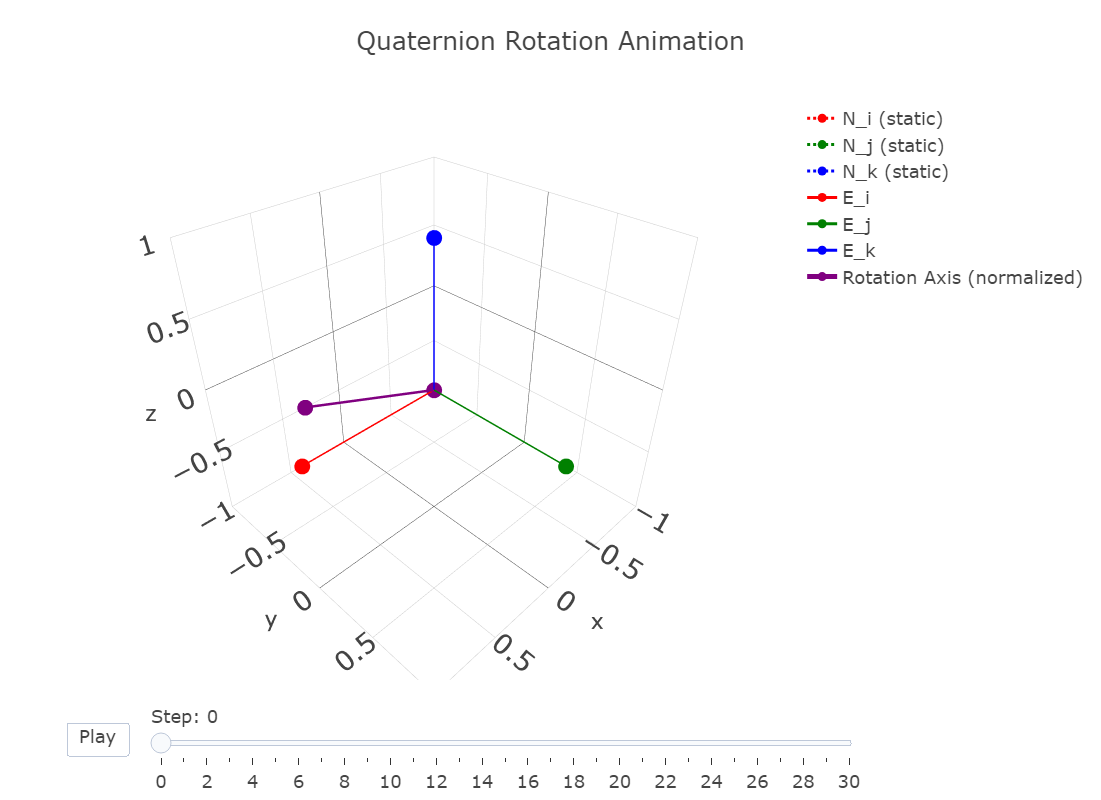

In [11]:
def Quaternion_rotation_animation(quaternion, steps=30):
    """
    Creates a 3D animation of a rotation represented by a quaternion and displays the final orientation of the frame.
    
    Args:
        quaternion (list, tuple, np.ndarray): The quaternion representing the rotation (in scalar-last format [q1, q2, q3, q4]).
        steps (int, optional): The total number of steps in the animation. Defaults to 30.
    
    Returns:
        plotly.graph_objects.Figure: The figure object containing the animation.
    """
    # Normalize the quaternion
    quaternion = np.array(quaternion)
    quaternion = quaternion / np.linalg.norm(quaternion)
    
    # Initialize the figure for 3D visualization
    fig = go.Figure()
    
    # Define initial orientation as an identity matrix
    N_frame = np.eye(3)
    
    # Define colors for axes
    colors = {'i': 'red', 'j': 'green', 'k': 'blue', 'axis': 'purple'}
    
    # Initialize the static frame (N-frame)
    initialize_ref_frame(fig, N_frame, 'N', colors, is_static=True)
    
    # Initialize the dynamic frame (E-frame)
    initialize_ref_frame(fig, N_frame, 'E', colors, is_static=False)
    
    # Identity quaternion
    q0 = np.array([0, 0, 0, 1])  # Scalar-last format
    
    # Time steps for interpolation
    t_array = np.linspace(0, 1, steps + 1)
    
    # Generate interpolated quaternions
    interpolated_quaternions = slerp(q0, quaternion, t_array)
    
    # Convert quaternions to rotation matrices
    rotation_matrices = [quaternion_to_DCM(q) for q in interpolated_quaternions]
    
    # Printing relevant Attitude representations
    DCM = rotation_matrices[-1]
    
    # Convert the final rotation matrix to Euler angles (3-2-1 sequence)
    first_rot = np.degrees(np.arctan2(DCM[0][1], DCM[0][0]))
    second_rot = np.degrees(np.arcsin(-DCM[0][2]))
    third_rot = np.degrees(np.arctan2(DCM[1][2], DCM[2][2]))
    
    print(f"Quaternion: {quaternion}")
    print("----------------------------------------------------")
    print(f"DCM:\n{DCM}")
    print("----------------------------------------------------")
    print(f"Euler Angles (321 sequence): <{first_rot}, {second_rot}, {third_rot}>")
    
    # Generate frames for animation
    frames = []
    for i, R_matrix in enumerate(rotation_matrices):
        E_frame = np.matmul(R_matrix, N_frame)
        
        frame_data = [
            go.Scatter3d(
                x=[0, vec[0]],
                y=[0, vec[1]],
                z=[0, vec[2]],
                mode='lines+markers',
                name=f'E_{axis_name}',
                marker=dict(color=colors[axis_name])
            )
            for vec, axis_name in zip(E_frame.T, ['i', 'j', 'k'])
        ]
        
        frames.append(go.Frame(data=frame_data, name=str(i), traces=[3, 4, 5]))
    
    # Extract rotation axis and angle for visualization
    angle = 2 * np.arccos(quaternion[3])
    sin_half_theta = np.sqrt(1 - quaternion[3]**2)
    if sin_half_theta < 1e-6:
        axis = np.array([1, 0, 0])  # Arbitrary axis if angle is zero
    else:
        axis = quaternion[:3] / sin_half_theta
    
    axis_normalized = axis / np.linalg.norm(axis)
    
    # Create hover text for the endpoint of the line
    endpoint_hover_text = f"x: {axis_normalized[0]:.2f}<br>y: {axis_normalized[1]:.2f}<br>z: {axis_normalized[2]:.2f}<br>Norm: {np.linalg.norm(axis_normalized):.2f}"
    
    # Plot the rotation axis
    fig.add_trace(go.Scatter3d(
        x=[0, axis_normalized[0]],
        y=[0, axis_normalized[1]],
        z=[0, axis_normalized[2]],
        mode='lines+markers',
        line=dict(color=colors['axis'], width=5),
        name='Rotation Axis (normalized)',
        hoverinfo='text+name',
        text=endpoint_hover_text
    ))
    
    # Configure the figure with generated frames for animation
    fig.frames = frames
    setup_animation_scene(fig, frames, "Quaternion Rotation Animation")
    
    return fig

# 90 degrees rotation around z-axis
angle_deg = 45
angle_rad = np.radians(angle_deg) / 2
quaternion = [1, 0, np.sin(angle_rad), np.cos(angle_rad)]  # Scalar-last format

fig = Quaternion_rotation_animation(quaternion)
fig.show()